<a href="https://colab.research.google.com/github/25thBaamDice/SerieDeTiempo/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

#from keras import initializers
#from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import load_model
#from tensorflow.keras.regularizers import l1, l2
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
%matplotlib inline

In [ ]:
DF= pd.read_csv('Datos_Serie.csv')

DF.index = DF['Fecha']

In [ ]:
DF.head()

,Fecha,VolPrec
Fecha,,
1963-01-01,1963-01-01,14.5
1963-02-01,1963-02-01,48.0
1963-03-01,1963-03-01,16.0
1963-04-01,1963-04-01,102.0
1963-05-01,1963-05-01,182.5


In [ ]:
df = pd.DataFrame(DF[['Fecha', 'VolPrec']])
#Poniendo los indices
df.index = df.Fecha
df.drop('Fecha', axis=1, inplace=True)
df.head()
df.tail()

,VolPrec
Fecha,
2017-11-01,47.0
2017-12-01,64.0
2018-01-01,21.9
2018-02-01,49.1
2018-03-01,45.8


In [ ]:
use_features = ['VolPrec'] # continuous input
target = ['VolPrec'] # continuous output
n_steps_ahead = 4 # forecasting horizon

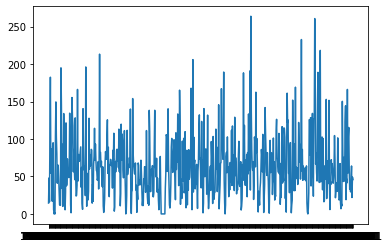

In [ ]:
plt.plot(df['VolPrec'])

In [ ]:
sample = df['VolPrec'][:800]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [ ]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -5.931380657399822
p-value: 2.3761385279567183e-07,
N: 648, 
critical values: {'1%': -3.4404817800778034, '5%': -2.866010569916275, '10%': -2.569150763698369}


In [ ]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

In [ ]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = float(df_train.mean())
sigma = float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

In [ ]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [ ]:
n_steps_ahead

4

In [ ]:
n_steps = 4

In [ ]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [ ]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(523, 4, 1), (523, 1), (126, 4, 1), (126, 1)]


In [ ]:
def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
max_epochs = 20 #Dejar mil
batch_size = 1000

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [ ]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [ ]:
params

{'rnn': {'model': None,
  'function': <function __main__.SimpleRNN_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 20,
  'color': 'blue',
  'label': 'RNN'},
 'gru': {'model': None,
  'function': <function __main__.GRU_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'orange',
  'label': 'GRU'},
 'lstm': {'model': None,
  'function': <function __main__.LSTM_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'red',
  'label': 'LSTM'}}

In [ ]:
do_training = True

In [ ]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\svill\AppData\Local\Temp/ipykernel_7464/719261985.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


Epoch 1/20
1/1 - 1s - loss: 2.1698 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 2.1532 - 12ms/epoch - 12ms/step
Epoch 3/20
1/1 - 0s - loss: 2.1367 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 2.1203 - 9ms/epoch - 9ms/step
Epoch 5/20
1/1 - 0s - loss: 2.1041 - 5ms/epoch - 5ms/step
Epoch 6/20
1/1 - 0s - loss: 2.0881 - 2ms/epoch - 2ms/step
Epoch 7/20
1/1 - 0s - loss: 2.0722 - 3ms/epoch - 3ms/step
Epoch 8/20
1/1 - 0s - loss: 2.0565 - 11ms/epoch - 11ms/step
Epoch 9/20
1/1 - 0s - loss: 2.0409 - 8ms/epoch - 8ms/step
Epoch 10/20
1/1 - 0s - loss: 2.0255 - 4ms/epoch - 4ms/step
Epoch 11/20
1/1 - 0s - loss: 2.0103 - 15ms/epoch - 15ms/step
Epoch 12/20
1/1 - 0s - loss: 1.9953 - 539us/epoch - 539us/step
Epoch 13/20
1/1 - 0s - loss: 1.9805 - 5ms/epoch - 5ms/step
Epoch 14/20
1/1 - 0s - loss: 1.9658 - 7ms/epoch - 7ms/step
Epoch 15/20
1/1 - 0s - loss: 1.9513 - 10ms/epoch - 10ms/step
Epoch 16/20
1/1 - 0s - loss: 1.9370 - 6ms/epoch - 6ms/step
Epoch 17/20
1/1 - 0s - loss: 1.9228 - 9ms/epoch - 9ms

1/1 - 0s - loss: 2.8304 - 8ms/epoch - 8ms/step
Epoch 17/20
1/1 - 0s - loss: 2.7994 - 5ms/epoch - 5ms/step
Epoch 18/20
1/1 - 0s - loss: 2.7692 - 9ms/epoch - 9ms/step
Epoch 19/20
1/1 - 0s - loss: 2.7396 - 7ms/epoch - 7ms/step
Epoch 20/20
1/1 - 0s - loss: 2.7105 - 8ms/epoch - 8ms/step
1/1 - 0s - loss: 2.0362 - 372ms/epoch - 372ms/step
[CV] END ...............................l1_reg=0, n_units=10; total time=   2.1s
Epoch 1/20
1/1 - 1s - loss: 1.4111 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 1.3993 - 9ms/epoch - 9ms/step
Epoch 3/20
1/1 - 0s - loss: 1.3880 - 13ms/epoch - 13ms/step
Epoch 4/20
1/1 - 0s - loss: 1.3769 - 10ms/epoch - 10ms/step
Epoch 5/20
1/1 - 0s - loss: 1.3663 - 9ms/epoch - 9ms/step
Epoch 6/20
1/1 - 0s - loss: 1.3559 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 1.3459 - 6ms/epoch - 6ms/step
Epoch 8/20
1/1 - 0s - loss: 1.3362 - 13ms/epoch - 13ms/step
Epoch 9/20
1/1 - 0s - loss: 1.3268 - 6ms/epoch - 6ms/step
Epoch 10/20
1/1 - 0s - loss: 1.3177 - 10ms/epoch - 10ms/s

1/1 - 0s - loss: 1.1778 - 9ms/epoch - 9ms/step
Epoch 10/20
1/1 - 0s - loss: 1.1548 - 14ms/epoch - 14ms/step
Epoch 11/20
1/1 - 0s - loss: 1.1336 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 1.1143 - 11ms/epoch - 11ms/step
Epoch 13/20
1/1 - 0s - loss: 1.0966 - 10ms/epoch - 10ms/step
Epoch 14/20
1/1 - 0s - loss: 1.0808 - 6ms/epoch - 6ms/step
Epoch 15/20
1/1 - 0s - loss: 1.0667 - 11ms/epoch - 11ms/step
Epoch 16/20
1/1 - 0s - loss: 1.0542 - 9ms/epoch - 9ms/step
Epoch 17/20
1/1 - 0s - loss: 1.0434 - 6ms/epoch - 6ms/step
Epoch 18/20
1/1 - 0s - loss: 1.0341 - 11ms/epoch - 11ms/step
Epoch 19/20
1/1 - 0s - loss: 1.0262 - 11ms/epoch - 11ms/step
Epoch 20/20
1/1 - 0s - loss: 1.0197 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 1.1522 - 330ms/epoch - 330ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=   2.0s
Epoch 1/20
1/1 - 1s - loss: 2.2694 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 2.2056 - 13ms/epoch - 13ms/step
Epoch 3/20
1/1 - 0s - loss: 2.1429 - 10ms/

Epoch 14/20
1/1 - 0s - loss: 4.7111 - 9ms/epoch - 9ms/step
Epoch 15/20
1/1 - 0s - loss: 4.6933 - 6ms/epoch - 6ms/step
Epoch 16/20
1/1 - 0s - loss: 4.6756 - 12ms/epoch - 12ms/step
Epoch 17/20
1/1 - 0s - loss: 4.6578 - 10ms/epoch - 10ms/step
Epoch 18/20
1/1 - 0s - loss: 4.6401 - 8ms/epoch - 8ms/step
Epoch 19/20
1/1 - 0s - loss: 4.6224 - 6ms/epoch - 6ms/step
Epoch 20/20
1/1 - 0s - loss: 4.6047 - 14ms/epoch - 14ms/step
1/1 - 0s - loss: 4.0681 - 320ms/epoch - 320ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=   2.1s
Epoch 1/20
1/1 - 1s - loss: 1.8211 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 1.8086 - 7ms/epoch - 7ms/step
Epoch 3/20
1/1 - 0s - loss: 1.7962 - 12ms/epoch - 12ms/step
Epoch 4/20
1/1 - 0s - loss: 1.7838 - 4ms/epoch - 4ms/step
Epoch 5/20
1/1 - 0s - loss: 1.7715 - 496us/epoch - 496us/step
Epoch 6/20
1/1 - 0s - loss: 1.7594 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 1.7473 - 14ms/epoch - 14ms/step
Epoch 8/20
1/1 - 0s - loss: 1.7354 

Epoch 19/20
1/1 - 0s - loss: 1.4902 - 12ms/epoch - 12ms/step
Epoch 20/20
1/1 - 0s - loss: 1.4760 - 10ms/epoch - 10ms/step
1/1 - 0s - loss: 2.0519 - 361ms/epoch - 361ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=   2.2s
Epoch 1/20
1/1 - 1s - loss: 1.1944 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 1.1842 - 4ms/epoch - 4ms/step
Epoch 3/20
1/1 - 0s - loss: 1.1744 - 8ms/epoch - 8ms/step
Epoch 4/20
1/1 - 0s - loss: 1.1649 - 9ms/epoch - 9ms/step
Epoch 5/20
1/1 - 0s - loss: 1.1559 - 14ms/epoch - 14ms/step
Epoch 6/20
1/1 - 0s - loss: 1.1472 - 11ms/epoch - 11ms/step
Epoch 7/20
1/1 - 0s - loss: 1.1389 - 6ms/epoch - 6ms/step
Epoch 8/20
1/1 - 0s - loss: 1.1310 - 7ms/epoch - 7ms/step
Epoch 9/20
1/1 - 0s - loss: 1.1234 - 4ms/epoch - 4ms/step
Epoch 10/20
1/1 - 0s - loss: 1.1161 - 8ms/epoch - 8ms/step
Epoch 11/20
1/1 - 0s - loss: 1.1092 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 1.1027 - 14ms/epoch - 14ms/step
Epoch 13/20
1/1 - 0s - loss: 1.0965 - 7ms

Epoch 2/20
1/1 - 0s - loss: 1.5426 - 10ms/epoch - 10ms/step
Epoch 3/20
1/1 - 0s - loss: 1.5350 - 8ms/epoch - 8ms/step
Epoch 4/20
1/1 - 0s - loss: 1.5275 - 11ms/epoch - 11ms/step
Epoch 5/20
1/1 - 0s - loss: 1.5201 - 10ms/epoch - 10ms/step
Epoch 6/20
1/1 - 0s - loss: 1.5128 - 6ms/epoch - 6ms/step
Epoch 7/20
1/1 - 0s - loss: 1.5056 - 8ms/epoch - 8ms/step
Epoch 8/20
1/1 - 0s - loss: 1.4985 - 9ms/epoch - 9ms/step
Epoch 9/20
1/1 - 0s - loss: 1.4915 - 11ms/epoch - 11ms/step
Epoch 10/20
1/1 - 0s - loss: 1.4846 - 9ms/epoch - 9ms/step
Epoch 11/20
1/1 - 0s - loss: 1.4778 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 1.4711 - 11ms/epoch - 11ms/step
Epoch 13/20
1/1 - 0s - loss: 1.4645 - 9ms/epoch - 9ms/step
Epoch 14/20
1/1 - 0s - loss: 1.4581 - 11ms/epoch - 11ms/step
Epoch 15/20
1/1 - 0s - loss: 1.4517 - 11ms/epoch - 11ms/step
Epoch 16/20
1/1 - 0s - loss: 1.4455 - 8ms/epoch - 8ms/step
Epoch 17/20
1/1 - 0s - loss: 1.4394 - 6ms/epoch - 6ms/step
Epoch 18/20
1/1 - 0s - loss: 1.4335 - 956us/epoc

Epoch 7/20
1/1 - 0s - loss: 2.6417 - 10ms/epoch - 10ms/step
Epoch 8/20
1/1 - 0s - loss: 2.5985 - 11ms/epoch - 11ms/step
Epoch 9/20
1/1 - 0s - loss: 2.5558 - 11ms/epoch - 11ms/step
Epoch 10/20
1/1 - 0s - loss: 2.5137 - 11ms/epoch - 11ms/step
Epoch 11/20
1/1 - 0s - loss: 2.4723 - 2ms/epoch - 2ms/step
Epoch 12/20
1/1 - 0s - loss: 2.4314 - 6ms/epoch - 6ms/step
Epoch 13/20
1/1 - 0s - loss: 2.3912 - 10ms/epoch - 10ms/step
Epoch 14/20
1/1 - 0s - loss: 2.3516 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 2.3126 - 11ms/epoch - 11ms/step
Epoch 16/20
1/1 - 0s - loss: 2.2742 - 9ms/epoch - 9ms/step
Epoch 17/20
1/1 - 0s - loss: 2.2365 - 5ms/epoch - 5ms/step
Epoch 18/20
1/1 - 0s - loss: 2.1994 - 10ms/epoch - 10ms/step
Epoch 19/20
1/1 - 0s - loss: 2.1629 - 10ms/epoch - 10ms/step
Epoch 20/20
1/1 - 0s - loss: 2.1271 - 9ms/epoch - 9ms/step
1/1 - 0s - loss: 1.0946 - 320ms/epoch - 320ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=   1.9s
Epoch 1/20
1/1 - 1s - loss:

1/1 - 0s - loss: 1.5062 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 1.4774 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 1.4497 - 7ms/epoch - 7ms/step
Epoch 14/20
1/1 - 0s - loss: 1.4234 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 1.3982 - 12ms/epoch - 12ms/step
Epoch 16/20
1/1 - 0s - loss: 1.3742 - 12ms/epoch - 12ms/step
Epoch 17/20
1/1 - 0s - loss: 1.3513 - 9ms/epoch - 9ms/step
Epoch 18/20
1/1 - 0s - loss: 1.3295 - 6ms/epoch - 6ms/step
Epoch 19/20
1/1 - 0s - loss: 1.3087 - 13ms/epoch - 13ms/step
Epoch 20/20
1/1 - 0s - loss: 1.2890 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 1.4086 - 339ms/epoch - 339ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=   2.1s
Epoch 1/20
1/1 - 1s - loss: 2.0671 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 2.0241 - 10ms/epoch - 10ms/step
Epoch 3/20
1/1 - 0s - loss: 1.9827 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 1.9428 - 6ms/epoch - 6ms/step
Epoch 5/20
1/1 - 0s - loss: 1.9046 - 10ms/ep

Epoch 16/20
1/1 - 0s - loss: 2.0438 - 10ms/epoch - 10ms/step
Epoch 17/20
1/1 - 0s - loss: 2.0310 - 10ms/epoch - 10ms/step
Epoch 18/20
1/1 - 0s - loss: 2.0183 - 11ms/epoch - 11ms/step
Epoch 19/20
1/1 - 0s - loss: 2.0057 - 9ms/epoch - 9ms/step
Epoch 20/20
1/1 - 0s - loss: 1.9933 - 6ms/epoch - 6ms/step
1/1 - 0s - loss: 2.0739 - 316ms/epoch - 316ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=   2.1s
Epoch 1/20
1/1 - 1s - loss: 4.3571 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 4.3313 - 12ms/epoch - 12ms/step
Epoch 3/20
1/1 - 0s - loss: 4.3058 - 11ms/epoch - 11ms/step
Epoch 4/20
1/1 - 0s - loss: 4.2804 - 5ms/epoch - 5ms/step
Epoch 5/20
1/1 - 0s - loss: 4.2552 - 9ms/epoch - 9ms/step
Epoch 6/20
1/1 - 0s - loss: 4.2302 - 5ms/epoch - 5ms/step
Epoch 7/20
1/1 - 0s - loss: 4.2055 - 10ms/epoch - 10ms/step
Epoch 8/20
1/1 - 0s - loss: 4.1809 - 11ms/epoch - 11ms/step
Epoch 9/20
1/1 - 0s - loss: 4.1566 - 7ms/epoch - 7ms/step
Epoch 10/20
1/1 - 0s - loss: 4.1324 - 7

1/1 - 0s - loss: 2.5885 - 304ms/epoch - 304ms/step
[CV] END .............................l1_reg=0.1, n_units=10; total time=   2.1s
Epoch 1/20
1/1 - 1s - loss: 3.7538 - 1s/epoch - 1s/step
Epoch 2/20
1/1 - 0s - loss: 3.6924 - 7ms/epoch - 7ms/step
Epoch 3/20
1/1 - 0s - loss: 3.6325 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 3.5741 - 12ms/epoch - 12ms/step
Epoch 5/20
1/1 - 0s - loss: 3.5172 - 8ms/epoch - 8ms/step
Epoch 6/20
1/1 - 0s - loss: 3.4618 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 3.4079 - 6ms/epoch - 6ms/step
Epoch 8/20
1/1 - 0s - loss: 3.3553 - 8ms/epoch - 8ms/step
Epoch 9/20
1/1 - 0s - loss: 3.3042 - 8ms/epoch - 8ms/step
Epoch 10/20
1/1 - 0s - loss: 3.2544 - 7ms/epoch - 7ms/step
Epoch 11/20
1/1 - 0s - loss: 3.2058 - 13ms/epoch - 13ms/step
Epoch 12/20
1/1 - 0s - loss: 3.1588 - 8ms/epoch - 8ms/step
Epoch 13/20
1/1 - 0s - loss: 3.1131 - 16ms/epoch - 16ms/step
Epoch 14/20
1/1 - 0s - loss: 3.0687 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 3.0256 - 6ms

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\svill\AppData\Local\Temp/ipykernel_7464/719261985.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


Epoch 1/20
1/1 - 4s - loss: 3.8411 - 4s/epoch - 4s/step
Epoch 2/20
1/1 - 0s - loss: 3.8140 - 10ms/epoch - 10ms/step
Epoch 3/20
1/1 - 0s - loss: 3.7870 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 3.7602 - 4ms/epoch - 4ms/step
Epoch 5/20
1/1 - 0s - loss: 3.7335 - 15ms/epoch - 15ms/step
Epoch 6/20
1/1 - 0s - loss: 3.7069 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 3.6805 - 9ms/epoch - 9ms/step
Epoch 8/20
1/1 - 0s - loss: 3.6543 - 6ms/epoch - 6ms/step
Epoch 9/20
1/1 - 0s - loss: 3.6281 - 8ms/epoch - 8ms/step
Epoch 10/20
1/1 - 0s - loss: 3.6022 - 11ms/epoch - 11ms/step
Epoch 11/20
1/1 - 0s - loss: 3.5763 - 8ms/epoch - 8ms/step
Epoch 12/20
1/1 - 0s - loss: 3.5507 - 11ms/epoch - 11ms/step
Epoch 13/20
1/1 - 0s - loss: 3.5252 - 10ms/epoch - 10ms/step
Epoch 14/20
1/1 - 0s - loss: 3.4998 - 14ms/epoch - 14ms/step
Epoch 15/20
1/1 - 0s - loss: 3.4746 - 8ms/epoch - 8ms/step
Epoch 16/20
1/1 - 0s - loss: 3.4496 - 11ms/epoch - 11ms/step
Epoch 17/20
1/1 - 0s - loss: 3.4248 - 9ms/epoch -

Epoch 6/20
1/1 - 0s - loss: 1.0764 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 1.0705 - 7ms/epoch - 7ms/step
Epoch 8/20
1/1 - 0s - loss: 1.0649 - 11ms/epoch - 11ms/step
Epoch 9/20
1/1 - 0s - loss: 1.0594 - 7ms/epoch - 7ms/step
Epoch 10/20
1/1 - 0s - loss: 1.0542 - 9ms/epoch - 9ms/step
Epoch 11/20
1/1 - 0s - loss: 1.0491 - 15ms/epoch - 15ms/step
Epoch 12/20
1/1 - 0s - loss: 1.0443 - 5ms/epoch - 5ms/step
Epoch 13/20
1/1 - 0s - loss: 1.0396 - 5ms/epoch - 5ms/step
Epoch 14/20
1/1 - 0s - loss: 1.0351 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 1.0308 - 5ms/epoch - 5ms/step
Epoch 16/20
1/1 - 0s - loss: 1.0267 - 12ms/epoch - 12ms/step
Epoch 17/20
1/1 - 0s - loss: 1.0228 - 7ms/epoch - 7ms/step
Epoch 18/20
1/1 - 0s - loss: 1.0191 - 8ms/epoch - 8ms/step
Epoch 19/20
1/1 - 0s - loss: 1.0156 - 7ms/epoch - 7ms/step
Epoch 20/20
1/1 - 0s - loss: 1.0122 - 6ms/epoch - 6ms/step
1/1 - 1s - loss: 0.7908 - 502ms/epoch - 502ms/step
[CV] END ...............................l1_reg=0, n_units=

1/1 - 0s - loss: 3.0489 - 12ms/epoch - 12ms/step
Epoch 11/20
1/1 - 0s - loss: 2.9999 - 7ms/epoch - 7ms/step
Epoch 12/20
1/1 - 0s - loss: 2.9515 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 2.9038 - 10ms/epoch - 10ms/step
Epoch 14/20
1/1 - 0s - loss: 2.8568 - 7ms/epoch - 7ms/step
Epoch 15/20
1/1 - 0s - loss: 2.8105 - 12ms/epoch - 12ms/step
Epoch 16/20
1/1 - 0s - loss: 2.7648 - 10ms/epoch - 10ms/step
Epoch 17/20
1/1 - 0s - loss: 2.7197 - 12ms/epoch - 12ms/step
Epoch 18/20
1/1 - 0s - loss: 2.6752 - 10ms/epoch - 10ms/step
Epoch 19/20
1/1 - 0s - loss: 2.6313 - 11ms/epoch - 11ms/step
Epoch 20/20
1/1 - 0s - loss: 2.5881 - 15ms/epoch - 15ms/step
1/1 - 0s - loss: 2.9262 - 436ms/epoch - 436ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=   3.5s
Epoch 1/20
1/1 - 3s - loss: 2.2168 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 0s - loss: 2.1771 - 9ms/epoch - 9ms/step
Epoch 3/20
1/1 - 0s - loss: 2.1379 - 17ms/epoch - 17ms/step
Epoch 4/20
1/1 - 0s - loss: 2.0992 - 14

1/1 - 0s - loss: 0.9639 - 12ms/epoch - 12ms/step
Epoch 15/20
1/1 - 0s - loss: 0.9630 - 11ms/epoch - 11ms/step
Epoch 16/20
1/1 - 0s - loss: 0.9621 - 7ms/epoch - 7ms/step
Epoch 17/20
1/1 - 0s - loss: 0.9612 - 9ms/epoch - 9ms/step
Epoch 18/20
1/1 - 0s - loss: 0.9604 - 7ms/epoch - 7ms/step
Epoch 19/20
1/1 - 0s - loss: 0.9597 - 10ms/epoch - 10ms/step
Epoch 20/20
1/1 - 0s - loss: 0.9590 - 11ms/epoch - 11ms/step
1/1 - 0s - loss: 1.3577 - 489ms/epoch - 489ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=   3.7s
Epoch 1/20
1/1 - 3s - loss: 1.8359 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 0s - loss: 1.8242 - 8ms/epoch - 8ms/step
Epoch 3/20
1/1 - 0s - loss: 1.8127 - 11ms/epoch - 11ms/step
Epoch 4/20
1/1 - 0s - loss: 1.8012 - 9ms/epoch - 9ms/step
Epoch 5/20
1/1 - 0s - loss: 1.7898 - 10ms/epoch - 10ms/step
Epoch 6/20
1/1 - 0s - loss: 1.7784 - 8ms/epoch - 8ms/step
Epoch 7/20
1/1 - 0s - loss: 1.7672 - 7ms/epoch - 7ms/step
Epoch 8/20
1/1 - 0s - loss: 1.7560 - 11ms/epoch - 1

Epoch 19/20
1/1 - 0s - loss: 1.9624 - 9ms/epoch - 9ms/step
Epoch 20/20
1/1 - 0s - loss: 1.9418 - 6ms/epoch - 6ms/step
1/1 - 0s - loss: 1.8067 - 473ms/epoch - 473ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=   3.6s
Epoch 1/20
1/1 - 2s - loss: 1.3242 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 0s - loss: 1.3122 - 11ms/epoch - 11ms/step
Epoch 3/20
1/1 - 0s - loss: 1.3008 - 6ms/epoch - 6ms/step
Epoch 4/20
1/1 - 0s - loss: 1.2900 - 7ms/epoch - 7ms/step
Epoch 5/20
1/1 - 0s - loss: 1.2798 - 16ms/epoch - 16ms/step
Epoch 6/20
1/1 - 0s - loss: 1.2702 - 11ms/epoch - 11ms/step
Epoch 7/20
1/1 - 0s - loss: 1.2613 - 12ms/epoch - 12ms/step
Epoch 8/20
1/1 - 0s - loss: 1.2530 - 7ms/epoch - 7ms/step
Epoch 9/20
1/1 - 0s - loss: 1.2453 - 11ms/epoch - 11ms/step
Epoch 10/20
1/1 - 0s - loss: 1.2383 - 10ms/epoch - 10ms/step
Epoch 11/20
1/1 - 0s - loss: 1.2319 - 13ms/epoch - 13ms/step
Epoch 12/20
1/1 - 0s - loss: 1.2261 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 1.2210 -

Epoch 1/20
1/1 - 2s - loss: 1.6465 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 0s - loss: 1.6364 - 12ms/epoch - 12ms/step
Epoch 3/20
1/1 - 0s - loss: 1.6264 - 6ms/epoch - 6ms/step
Epoch 4/20
1/1 - 0s - loss: 1.6165 - 8ms/epoch - 8ms/step
Epoch 5/20
1/1 - 0s - loss: 1.6066 - 10ms/epoch - 10ms/step
Epoch 6/20
1/1 - 0s - loss: 1.5968 - 8ms/epoch - 8ms/step
Epoch 7/20
1/1 - 0s - loss: 1.5871 - 12ms/epoch - 12ms/step
Epoch 8/20
1/1 - 0s - loss: 1.5775 - 8ms/epoch - 8ms/step
Epoch 9/20
1/1 - 0s - loss: 1.5680 - 13ms/epoch - 13ms/step
Epoch 10/20
1/1 - 0s - loss: 1.5586 - 8ms/epoch - 8ms/step
Epoch 11/20
1/1 - 0s - loss: 1.5493 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 1.5400 - 7ms/epoch - 7ms/step
Epoch 13/20
1/1 - 0s - loss: 1.5309 - 7ms/epoch - 7ms/step
Epoch 14/20
1/1 - 0s - loss: 1.5218 - 4ms/epoch - 4ms/step
Epoch 15/20
1/1 - 0s - loss: 1.5129 - 10ms/epoch - 10ms/step
Epoch 16/20
1/1 - 0s - loss: 1.5040 - 5ms/epoch - 5ms/step
Epoch 17/20
1/1 - 0s - loss: 1.4952 - 6ms/epoch - 6ms/s

Epoch 6/20
1/1 - 0s - loss: 1.4338 - 7ms/epoch - 7ms/step
Epoch 7/20
1/1 - 0s - loss: 1.4205 - 13ms/epoch - 13ms/step
Epoch 8/20
1/1 - 0s - loss: 1.4075 - 17ms/epoch - 17ms/step
Epoch 9/20
1/1 - 0s - loss: 1.3947 - 14ms/epoch - 14ms/step
Epoch 10/20
1/1 - 0s - loss: 1.3822 - 12ms/epoch - 12ms/step
Epoch 11/20
1/1 - 0s - loss: 1.3699 - 10ms/epoch - 10ms/step
Epoch 12/20
1/1 - 0s - loss: 1.3578 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 1.3460 - 8ms/epoch - 8ms/step
Epoch 14/20
1/1 - 0s - loss: 1.3345 - 10ms/epoch - 10ms/step
Epoch 15/20
1/1 - 0s - loss: 1.3232 - 6ms/epoch - 6ms/step
Epoch 16/20
1/1 - 0s - loss: 1.3121 - 10ms/epoch - 10ms/step
Epoch 17/20
1/1 - 0s - loss: 1.3013 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 1.2908 - 10ms/epoch - 10ms/step
Epoch 19/20
1/1 - 0s - loss: 1.2805 - 14ms/epoch - 14ms/step
Epoch 20/20
1/1 - 0s - loss: 1.2704 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 1.1258 - 456ms/epoch - 456ms/step
[CV] END ............................l1_reg=0.01

1/1 - 0s - loss: 1.2910 - 11ms/epoch - 11ms/step
Epoch 11/20
1/1 - 0s - loss: 1.2746 - 4ms/epoch - 4ms/step
Epoch 12/20
1/1 - 0s - loss: 1.2590 - 9ms/epoch - 9ms/step
Epoch 13/20
1/1 - 0s - loss: 1.2441 - 15ms/epoch - 15ms/step
Epoch 14/20
1/1 - 0s - loss: 1.2300 - 11ms/epoch - 11ms/step
Epoch 15/20
1/1 - 0s - loss: 1.2166 - 10ms/epoch - 10ms/step
Epoch 16/20
1/1 - 0s - loss: 1.2040 - 12ms/epoch - 12ms/step
Epoch 17/20
1/1 - 0s - loss: 1.1920 - 10ms/epoch - 10ms/step
Epoch 18/20
1/1 - 0s - loss: 1.1807 - 13ms/epoch - 13ms/step
Epoch 19/20
1/1 - 0s - loss: 1.1702 - 7ms/epoch - 7ms/step
Epoch 20/20
1/1 - 0s - loss: 1.1603 - 20ms/epoch - 20ms/step
1/1 - 0s - loss: 1.4302 - 437ms/epoch - 437ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=   3.4s
Epoch 1/20
1/1 - 2s - loss: 3.9662 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 0s - loss: 3.9044 - 11ms/epoch - 11ms/step
Epoch 3/20
1/1 - 0s - loss: 3.8436 - 7ms/epoch - 7ms/step
Epoch 4/20
1/1 - 0s - loss: 3.7839 - 9ms/

Epoch 15/20
1/1 - 0s - loss: 1.8778 - 10ms/epoch - 10ms/step
Epoch 16/20
1/1 - 0s - loss: 1.8719 - 11ms/epoch - 11ms/step
Epoch 17/20
1/1 - 0s - loss: 1.8662 - 7ms/epoch - 7ms/step
Epoch 18/20
1/1 - 0s - loss: 1.8605 - 9ms/epoch - 9ms/step
Epoch 19/20
1/1 - 0s - loss: 1.8549 - 11ms/epoch - 11ms/step
Epoch 20/20
1/1 - 0s - loss: 1.8493 - 11ms/epoch - 11ms/step
1/1 - 0s - loss: 1.7239 - 450ms/epoch - 450ms/step
[CV] END ..............................l1_reg=0.1, n_units=5; total time=   4.0s
Epoch 1/20
1/1 - 2s - loss: 2.5235 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 0s - loss: 2.5099 - 3ms/epoch - 3ms/step
Epoch 3/20
1/1 - 0s - loss: 2.4965 - 9ms/epoch - 9ms/step
Epoch 4/20
1/1 - 0s - loss: 2.4833 - 11ms/epoch - 11ms/step
Epoch 5/20
1/1 - 0s - loss: 2.4702 - 12ms/epoch - 12ms/step
Epoch 6/20
1/1 - 0s - loss: 2.4573 - 11ms/epoch - 11ms/step
Epoch 7/20
1/1 - 0s - loss: 2.4446 - 10ms/epoch - 10ms/step
Epoch 8/20
1/1 - 0s - loss: 2.4321 - 12ms/epoch - 12ms/step
Epoch 9/20
1/1 - 0s - loss: 2.4197

Epoch 20/20
1/1 - 0s - loss: 3.1466 - 6ms/epoch - 6ms/step
1/1 - 0s - loss: 2.5461 - 438ms/epoch - 438ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=   3.4s
Epoch 1/20
1/1 - 3s - loss: 2.5286 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 0s - loss: 2.5119 - 16ms/epoch - 16ms/step
Epoch 3/20
1/1 - 0s - loss: 2.4957 - 10ms/epoch - 10ms/step
Epoch 4/20
1/1 - 0s - loss: 2.4799 - 10ms/epoch - 10ms/step
Epoch 5/20
1/1 - 0s - loss: 2.4647 - 9ms/epoch - 9ms/step
Epoch 6/20
1/1 - 0s - loss: 2.4502 - 8ms/epoch - 8ms/step
Epoch 7/20
1/1 - 0s - loss: 2.4362 - 6ms/epoch - 6ms/step
Epoch 8/20
1/1 - 0s - loss: 2.4226 - 10ms/epoch - 10ms/step
Epoch 9/20
1/1 - 0s - loss: 2.4095 - 11ms/epoch - 11ms/step
Epoch 10/20
1/1 - 0s - loss: 2.3967 - 13ms/epoch - 13ms/step
Epoch 11/20
1/1 - 0s - loss: 2.3843 - 9ms/epoch - 9ms/step
Epoch 12/20
1/1 - 0s - loss: 2.3724 - 14ms/epoch - 14ms/step
Epoch 13/20
1/1 - 0s - loss: 2.3609 - 10ms/epoch - 10ms/step
Epoch 14/20
1/1 - 0s - loss: 2.3497 -

C:\Users\svill\AppData\Local\Temp/ipykernel_7464/719261985.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


Epoch 1/20
1/1 - 2s - loss: 1.5231 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 0s - loss: 1.5175 - 10ms/epoch - 10ms/step
Epoch 3/20
1/1 - 0s - loss: 1.5119 - 983us/epoch - 983us/step
Epoch 4/20
1/1 - 0s - loss: 1.5065 - 7ms/epoch - 7ms/step
Epoch 5/20
1/1 - 0s - loss: 1.5011 - 8ms/epoch - 8ms/step
Epoch 6/20
1/1 - 0s - loss: 1.4957 - 12ms/epoch - 12ms/step
Epoch 7/20
1/1 - 0s - loss: 1.4904 - 12ms/epoch - 12ms/step
Epoch 8/20
1/1 - 0s - loss: 1.4852 - 10ms/epoch - 10ms/step
Epoch 9/20
1/1 - 0s - loss: 1.4801 - 11ms/epoch - 11ms/step
Epoch 10/20
1/1 - 0s - loss: 1.4750 - 10ms/epoch - 10ms/step
Epoch 11/20
1/1 - 0s - loss: 1.4700 - 9ms/epoch - 9ms/step
Epoch 12/20
1/1 - 0s - loss: 1.4651 - 11ms/epoch - 11ms/step
Epoch 13/20
1/1 - 0s - loss: 1.4602 - 13ms/epoch - 13ms/step
Epoch 14/20
1/1 - 0s - loss: 1.4554 - 2ms/epoch - 2ms/step
Epoch 15/20
1/1 - 0s - loss: 1.4507 - 9ms/epoch - 9ms/step
Epoch 16/20
1/1 - 0s - loss: 1.4461 - 12ms/epoch - 12ms/step
Epoch 17/20
1/1 - 0s - loss: 1.4415 - 14ms/ep

Epoch 6/20
1/1 - 0s - loss: 1.0566 - 14ms/epoch - 14ms/step
Epoch 7/20
1/1 - 0s - loss: 1.0540 - 11ms/epoch - 11ms/step
Epoch 8/20
1/1 - 0s - loss: 1.0515 - 7ms/epoch - 7ms/step
Epoch 9/20
1/1 - 0s - loss: 1.0490 - 15ms/epoch - 15ms/step
Epoch 10/20
1/1 - 0s - loss: 1.0466 - 8ms/epoch - 8ms/step
Epoch 11/20
1/1 - 0s - loss: 1.0443 - 6ms/epoch - 6ms/step
Epoch 12/20
1/1 - 0s - loss: 1.0420 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 1.0398 - 14ms/epoch - 14ms/step
Epoch 14/20
1/1 - 0s - loss: 1.0377 - 12ms/epoch - 12ms/step
Epoch 15/20
1/1 - 0s - loss: 1.0356 - 10ms/epoch - 10ms/step
Epoch 16/20
1/1 - 0s - loss: 1.0336 - 9ms/epoch - 9ms/step
Epoch 17/20
1/1 - 0s - loss: 1.0317 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 1.0298 - 12ms/epoch - 12ms/step
Epoch 19/20
1/1 - 0s - loss: 1.0279 - 12ms/epoch - 12ms/step
Epoch 20/20
1/1 - 0s - loss: 1.0262 - 13ms/epoch - 13ms/step
1/1 - 0s - loss: 0.7993 - 438ms/epoch - 438ms/step
[CV] END ...............................l1_reg=0

Epoch 10/20
1/1 - 0s - loss: 3.0695 - 16ms/epoch - 16ms/step
Epoch 11/20
1/1 - 0s - loss: 3.0404 - 20ms/epoch - 20ms/step
Epoch 12/20
1/1 - 0s - loss: 3.0115 - 14ms/epoch - 14ms/step
Epoch 13/20
1/1 - 0s - loss: 2.9828 - 10ms/epoch - 10ms/step
Epoch 14/20
1/1 - 0s - loss: 2.9541 - 13ms/epoch - 13ms/step
Epoch 15/20
1/1 - 0s - loss: 2.9256 - 13ms/epoch - 13ms/step
Epoch 16/20
1/1 - 0s - loss: 2.8972 - 10ms/epoch - 10ms/step
Epoch 17/20
1/1 - 0s - loss: 2.8688 - 14ms/epoch - 14ms/step
Epoch 18/20
1/1 - 0s - loss: 2.8405 - 10ms/epoch - 10ms/step
Epoch 19/20
1/1 - 0s - loss: 2.8123 - 11ms/epoch - 11ms/step
Epoch 20/20
1/1 - 0s - loss: 2.7841 - 7ms/epoch - 7ms/step
1/1 - 0s - loss: 3.1468 - 429ms/epoch - 429ms/step
[CV] END ...............................l1_reg=0, n_units=20; total time=   3.0s
Epoch 1/20
1/1 - 2s - loss: 1.8178 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 0s - loss: 1.7975 - 20ms/epoch - 20ms/step
Epoch 3/20
1/1 - 0s - loss: 1.7774 - 13ms/epoch - 13ms/step
Epoch 4/20
1/1 - 0s - l

1/1 - 0s - loss: 1.4268 - 8ms/epoch - 8ms/step
Epoch 15/20
1/1 - 0s - loss: 1.4200 - 10ms/epoch - 10ms/step
Epoch 16/20
1/1 - 0s - loss: 1.4133 - 6ms/epoch - 6ms/step
Epoch 17/20
1/1 - 0s - loss: 1.4066 - 10ms/epoch - 10ms/step
Epoch 18/20
1/1 - 0s - loss: 1.4000 - 10ms/epoch - 10ms/step
Epoch 19/20
1/1 - 0s - loss: 1.3934 - 10ms/epoch - 10ms/step
Epoch 20/20
1/1 - 0s - loss: 1.3868 - 8ms/epoch - 8ms/step
1/1 - 0s - loss: 1.4332 - 420ms/epoch - 420ms/step
[CV] END ............................l1_reg=0.001, n_units=5; total time=   3.2s
Epoch 1/20
1/1 - 3s - loss: 1.4761 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 0s - loss: 1.4696 - 12ms/epoch - 12ms/step
Epoch 3/20
1/1 - 0s - loss: 1.4633 - 13ms/epoch - 13ms/step
Epoch 4/20
1/1 - 0s - loss: 1.4570 - 15ms/epoch - 15ms/step
Epoch 5/20
1/1 - 0s - loss: 1.4507 - 8ms/epoch - 8ms/step
Epoch 6/20
1/1 - 0s - loss: 1.4446 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 1.4385 - 5ms/epoch - 5ms/step
Epoch 8/20
1/1 - 0s - loss: 1.4325 - 9ms/epoch 

1/1 - 0s - loss: 2.5615 - 6ms/epoch - 6ms/step
Epoch 20/20
1/1 - 0s - loss: 2.5441 - 9ms/epoch - 9ms/step
1/1 - 0s - loss: 2.1917 - 178ms/epoch - 178ms/step
[CV] END ...........................l1_reg=0.001, n_units=10; total time=   1.1s
Epoch 1/20
1/1 - 1s - loss: 1.2430 - 891ms/epoch - 891ms/step
Epoch 2/20
1/1 - 0s - loss: 1.2410 - 5ms/epoch - 5ms/step
Epoch 3/20
1/1 - 0s - loss: 1.2391 - 2ms/epoch - 2ms/step
Epoch 4/20
1/1 - 0s - loss: 1.2374 - 10ms/epoch - 10ms/step
Epoch 5/20
1/1 - 0s - loss: 1.2358 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 1.2344 - 0s/epoch - 0s/step
Epoch 7/20
1/1 - 0s - loss: 1.2331 - 4ms/epoch - 4ms/step
Epoch 8/20
1/1 - 0s - loss: 1.2318 - 9ms/epoch - 9ms/step
Epoch 9/20
1/1 - 0s - loss: 1.2307 - 10ms/epoch - 10ms/step
Epoch 10/20
1/1 - 0s - loss: 1.2296 - 0s/epoch - 0s/step
Epoch 11/20
1/1 - 0s - loss: 1.2286 - 506us/epoch - 506us/step
Epoch 12/20
1/1 - 0s - loss: 1.2276 - 5ms/epoch - 5ms/step
Epoch 13/20
1/1 - 0s - loss: 1.2266 - 6ms/epoch - 6ms/ste

Epoch 3/20
1/1 - 0s - loss: 1.7721 - 8ms/epoch - 8ms/step
Epoch 4/20
1/1 - 0s - loss: 1.7637 - 0s/epoch - 0s/step
Epoch 5/20
1/1 - 0s - loss: 1.7553 - 0s/epoch - 0s/step
Epoch 6/20
1/1 - 0s - loss: 1.7471 - 10ms/epoch - 10ms/step
Epoch 7/20
1/1 - 0s - loss: 1.7389 - 8ms/epoch - 8ms/step
Epoch 8/20
1/1 - 0s - loss: 1.7308 - 6ms/epoch - 6ms/step
Epoch 9/20
1/1 - 0s - loss: 1.7228 - 4ms/epoch - 4ms/step
Epoch 10/20
1/1 - 0s - loss: 1.7149 - 7ms/epoch - 7ms/step
Epoch 11/20
1/1 - 0s - loss: 1.7070 - 1ms/epoch - 1ms/step
Epoch 12/20
1/1 - 0s - loss: 1.6993 - 5ms/epoch - 5ms/step
Epoch 13/20
1/1 - 0s - loss: 1.6916 - 7ms/epoch - 7ms/step
Epoch 14/20
1/1 - 0s - loss: 1.6840 - 3ms/epoch - 3ms/step
Epoch 15/20
1/1 - 0s - loss: 1.6765 - 7ms/epoch - 7ms/step
Epoch 16/20
1/1 - 0s - loss: 1.6691 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 1.6618 - 6ms/epoch - 6ms/step
Epoch 18/20
1/1 - 0s - loss: 1.6545 - 2ms/epoch - 2ms/step
Epoch 19/20
1/1 - 0s - loss: 1.6474 - 6ms/epoch - 6ms/step
Epoch 20

Epoch 10/20
1/1 - 0s - loss: 1.2050 - 4ms/epoch - 4ms/step
Epoch 11/20
1/1 - 0s - loss: 1.2000 - 7ms/epoch - 7ms/step
Epoch 12/20
1/1 - 0s - loss: 1.1952 - 10ms/epoch - 10ms/step
Epoch 13/20
1/1 - 0s - loss: 1.1904 - 3ms/epoch - 3ms/step
Epoch 14/20
1/1 - 0s - loss: 1.1857 - 8ms/epoch - 8ms/step
Epoch 15/20
1/1 - 0s - loss: 1.1811 - 9ms/epoch - 9ms/step
Epoch 16/20
1/1 - 0s - loss: 1.1766 - 9ms/epoch - 9ms/step
Epoch 17/20
1/1 - 0s - loss: 1.1722 - 0s/epoch - 0s/step
Epoch 18/20
1/1 - 0s - loss: 1.1678 - 11ms/epoch - 11ms/step
Epoch 19/20
1/1 - 0s - loss: 1.1636 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 1.1594 - 7ms/epoch - 7ms/step
1/1 - 0s - loss: 1.0698 - 180ms/epoch - 180ms/step
[CV] END ............................l1_reg=0.01, n_units=10; total time=   1.3s
Epoch 1/20
1/1 - 1s - loss: 1.0685 - 928ms/epoch - 928ms/step
Epoch 2/20
1/1 - 0s - loss: 1.0666 - 5ms/epoch - 5ms/step
Epoch 3/20
1/1 - 0s - loss: 1.0648 - 0s/epoch - 0s/step
Epoch 4/20
1/1 - 0s - loss: 1.0631 - 11ms/e

1/1 - 0s - loss: 1.3427 - 10ms/epoch - 10ms/step
Epoch 17/20
1/1 - 0s - loss: 1.3326 - 0s/epoch - 0s/step
Epoch 18/20
1/1 - 0s - loss: 1.3226 - 8ms/epoch - 8ms/step
Epoch 19/20
1/1 - 0s - loss: 1.3127 - 0s/epoch - 0s/step
Epoch 20/20
1/1 - 0s - loss: 1.3030 - 9ms/epoch - 9ms/step
1/1 - 0s - loss: 1.8314 - 182ms/epoch - 182ms/step
[CV] END ............................l1_reg=0.01, n_units=20; total time=   1.0s
Epoch 1/20
1/1 - 1s - loss: 1.7220 - 885ms/epoch - 885ms/step
Epoch 2/20
1/1 - 0s - loss: 1.7026 - 13ms/epoch - 13ms/step
Epoch 3/20
1/1 - 0s - loss: 1.6837 - 11ms/epoch - 11ms/step
Epoch 4/20
1/1 - 0s - loss: 1.6651 - 15ms/epoch - 15ms/step
Epoch 5/20
1/1 - 0s - loss: 1.6470 - 10ms/epoch - 10ms/step
Epoch 6/20
1/1 - 0s - loss: 1.6292 - 8ms/epoch - 8ms/step
Epoch 7/20
1/1 - 0s - loss: 1.6119 - 8ms/epoch - 8ms/step
Epoch 8/20
1/1 - 0s - loss: 1.5949 - 4ms/epoch - 4ms/step
Epoch 9/20
1/1 - 0s - loss: 1.5784 - 3ms/epoch - 3ms/step
Epoch 10/20
1/1 - 0s - loss: 1.5622 - 10ms/epoch - 10

Epoch 1/20
1/1 - 1s - loss: 5.2955 - 805ms/epoch - 805ms/step
Epoch 2/20
1/1 - 0s - loss: 5.2674 - 0s/epoch - 0s/step
Epoch 3/20
1/1 - 0s - loss: 5.2397 - 0s/epoch - 0s/step
Epoch 4/20
1/1 - 0s - loss: 5.2121 - 11ms/epoch - 11ms/step
Epoch 5/20
1/1 - 0s - loss: 5.1847 - 8ms/epoch - 8ms/step
Epoch 6/20
1/1 - 0s - loss: 5.1574 - 9ms/epoch - 9ms/step
Epoch 7/20
1/1 - 0s - loss: 5.1302 - 7ms/epoch - 7ms/step
Epoch 8/20
1/1 - 0s - loss: 5.1032 - 6ms/epoch - 6ms/step
Epoch 9/20
1/1 - 0s - loss: 5.0763 - 7ms/epoch - 7ms/step
Epoch 10/20
1/1 - 0s - loss: 5.0496 - 8ms/epoch - 8ms/step
Epoch 11/20
1/1 - 0s - loss: 5.0230 - 9ms/epoch - 9ms/step
Epoch 12/20
1/1 - 0s - loss: 4.9967 - 0s/epoch - 0s/step
Epoch 13/20
1/1 - 0s - loss: 4.9706 - 11ms/epoch - 11ms/step
Epoch 14/20
1/1 - 0s - loss: 4.9445 - 9ms/epoch - 9ms/step
Epoch 15/20
1/1 - 0s - loss: 4.9186 - 8ms/epoch - 8ms/step
Epoch 16/20
1/1 - 0s - loss: 4.8927 - 0s/epoch - 0s/step
Epoch 17/20
1/1 - 0s - loss: 4.8670 - 10ms/epoch - 10ms/step
Epoc

Epoch 8/20
1/1 - 0s - loss: 5.9707 - 0s/epoch - 0s/step
Epoch 9/20
1/1 - 0s - loss: 5.9332 - 10ms/epoch - 10ms/step
Epoch 10/20
1/1 - 0s - loss: 5.8961 - 9ms/epoch - 9ms/step
Epoch 11/20
1/1 - 0s - loss: 5.8592 - 0s/epoch - 0s/step
Epoch 12/20
1/1 - 0s - loss: 5.8225 - 0s/epoch - 0s/step
Epoch 13/20
1/1 - 0s - loss: 5.7862 - 0s/epoch - 0s/step
Epoch 14/20
1/1 - 0s - loss: 5.7501 - 0s/epoch - 0s/step
Epoch 15/20
1/1 - 0s - loss: 5.7143 - 1ms/epoch - 1ms/step
Epoch 16/20
1/1 - 0s - loss: 5.6786 - 11ms/epoch - 11ms/step
Epoch 17/20
1/1 - 0s - loss: 5.6431 - 8ms/epoch - 8ms/step
Epoch 18/20
1/1 - 0s - loss: 5.6077 - 6ms/epoch - 6ms/step
Epoch 19/20
1/1 - 0s - loss: 5.5726 - 4ms/epoch - 4ms/step
Epoch 20/20
1/1 - 0s - loss: 5.5376 - 8ms/epoch - 8ms/step
1/1 - 0s - loss: 3.9958 - 161ms/epoch - 161ms/step
[CV] END .............................l1_reg=0.1, n_units=20; total time=   1.3s
Epoch 1/20
1/1 - 1s - loss: 3.4208 - 611ms/epoch - 611ms/step
Epoch 2/20
1/1 - 0s - loss: 3.3950 - 0s/epoch -

In [ ]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/20
1/1 [==============================] - 0s 391ms/step - loss: 2.6280
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 2.5688
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 2.5107
Epoch 4/20
1/1 [==============================] - 0s 4ms/step - loss: 2.4537
Epoch 5/20
1/1 [==============================] - 0s 4ms/step - loss: 2.3978
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 2.3430
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 2.2890
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 2.2358
Epoch 9/20
1/1 [==============================] - 0s 8ms/step - loss: 2.1833
Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 2.1314
Epoch 11/20
1/1 [==============================] - 0s 9ms/step - loss: 2.0800
Epoch 12/20
1/1 [==============================] - 0s 8ms/step - loss: 2.0291
Epoch 13/20
1/1 [==============================] 

In [ ]:
for key in params.keys():
    params[key]['model'].save('RNNs-Bitcoin-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

In [ ]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_61 (SimpleRNN)   (None, 20)                440       
                                                                 
 dense_183 (Dense)           (None, 1)                 21        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 3ms/step
Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_61 (GRU)                (None, 20)                1380      
                                                                 
 dense_184 (Dense)           (None, 1)                 21        
                                             

In [ ]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

training set: 523
testing set: 126


In [ ]:
print(params.keys())

# Set `compare` in the cells below to a list
# containing any subset of these:

dict_keys(['rnn', 'gru', 'lstm'])


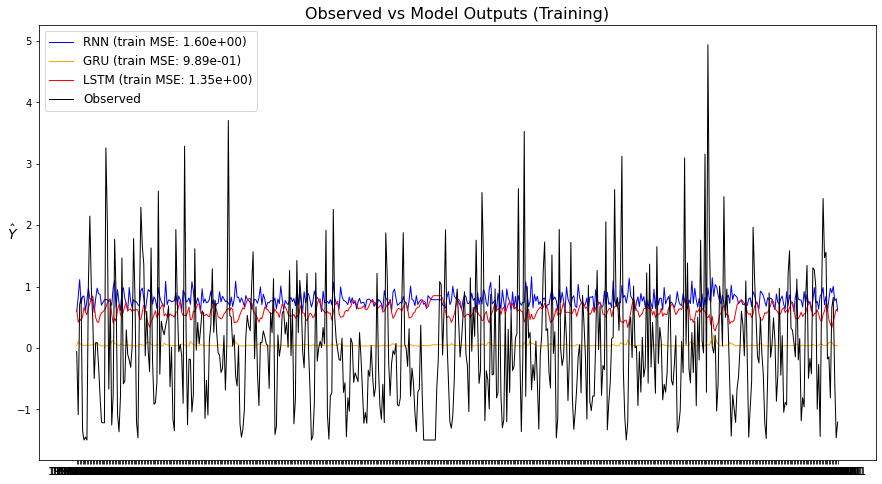

In [ ]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

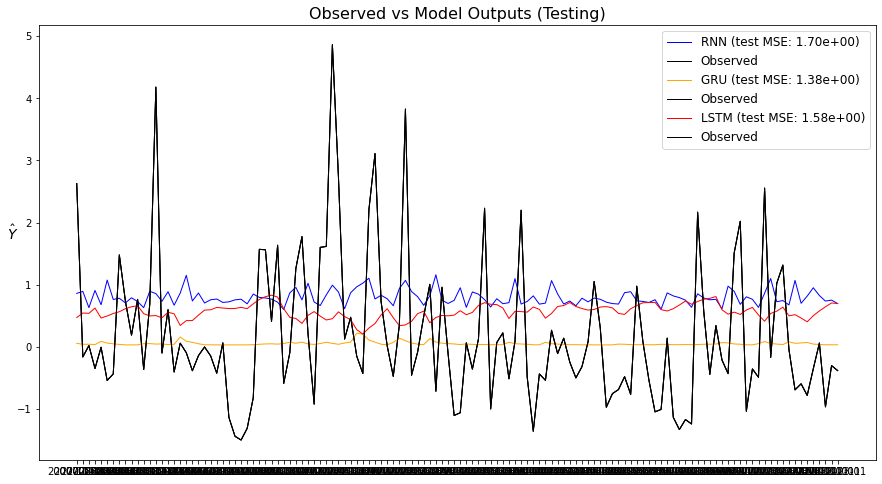

In [ ]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
    plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

NameError: name 'xticks' is not defined

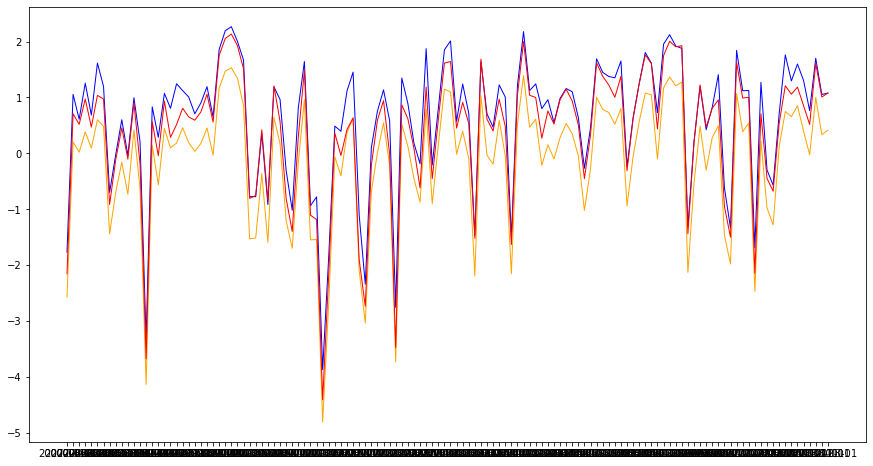

In [ ]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

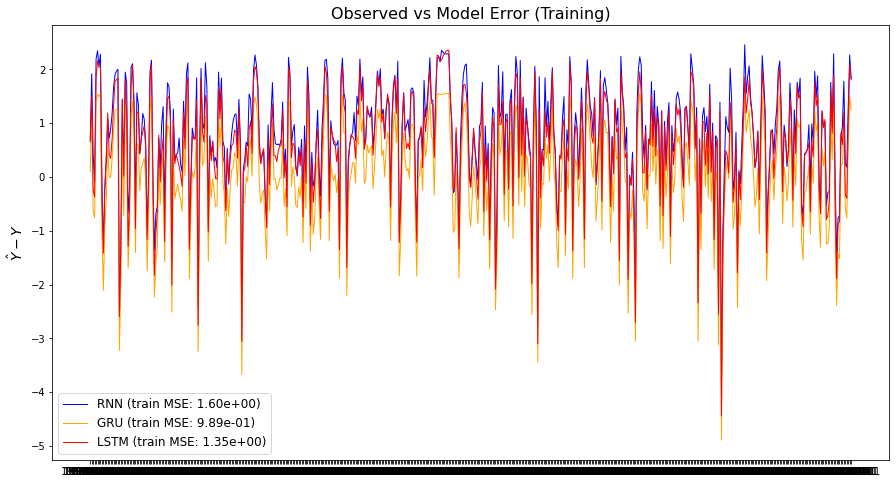

In [ ]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);